# 01 — Enrega

**Objetivo:** solo cargar datos y producir graficos 

Salidas:
1) Distribución de clases (solo train.csv).
2) Auto‑detectada: geografía / programa / estrato / modalidad / institución.


In [28]:
!pip install --upgrade pip
!pip install numpy pandas scikit-learn matplotlib

In [29]:
import os, re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = "."
TRAIN_PATH = os.path.join(DATA_DIR, "train.csv")
TEST_PATH  = os.path.join(DATA_DIR, "test.csv")

OUT_FIGS = Path("figs"); OUT_FIGS.mkdir(exist_ok=True)

print("train.csv:", os.path.abspath(TRAIN_PATH))
print("test.csv :", os.path.abspath(TEST_PATH))

train.csv: c:\Users\user\Downloads\udea-ai-4-eng-20252-pruebas-saber-pro-colombia\train.csv
test.csv : c:\Users\user\Downloads\udea-ai-4-eng-20252-pruebas-saber-pro-colombia\test.csv


## 1) Carga rápida

In [30]:
train = pd.read_csv(TRAIN_PATH)
print("TRAIN shape:", train.shape)
display(train.head(8))

test = None
if os.path.exists(TEST_PATH):
    test = pd.read_csv(TEST_PATH)
    print("TEST shape:", test.shape)

TRAIN shape: (692500, 21)


,ID,PERIODO_ACADEMICO,E_PRGM_ACADEMICO,E_PRGM_DEPARTAMENTO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_ESTRATOVIVIENDA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,...,E_PRIVADO_LIBERTAD,E_PAGOMATRICULAPROPIO,F_TIENECOMPUTADOR,F_TIENEINTERNET.1,F_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,...,N,No,Si,Si,Postgrado,medio-alto,0.322,0.208,0.310,0.267
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,...,N,No,Si,No,Técnica o tecnológica incompleta,bajo,0.311,0.215,0.292,0.264
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,...,N,No,No,Si,Secundaria (Bachillerato) completa,bajo,0.297,0.214,0.305,0.264
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Si,...,N,No,Si,Si,Secundaria (Bachillerato) completa,alto,0.485,0.172,0.252,0.190
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Si,...,N,No,Si,Si,Primaria completa,medio-bajo,0.316,0.232,0.285,0.294
5,659872,20203,MEDICINA VETERINARIA,ANTIOQUIA,Más de 7 millones,Menos de 10 horas,Estrato 5,Si,Educación profesional completa,Si,...,N,No,Si,Si,Secundaria (Bachillerato) completa,medio-alto,0.553,0.142,0.248,0.175
6,47159,20183,INGENIERIA MECANICA,HUILA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 2,Si,Educación profesional incompleta,Si,...,N,Si,Si,Si,Técnica o tecnológica completa,alto,0.242,0.299,0.267,0.308
7,11829,20183,ADMINISTRACIÓN EN SALUD OCUPACIONAL,BOGOTÁ,Entre 1 millón y menos de 2.5 millones,Entre 11 y 20 horas,Estrato 2,Si,Primaria incompleta,Si,...,N,Si,No,Si,Secundaria (Bachillerato) incompleta,medio-bajo,0.238,0.316,0.286,0.290


TEST shape: (296786, 20)


## 2) Distribución de clases 

Columna de clase: RENDIMIENTO_GLOBAL


RENDIMIENTO_GLOBAL
alto          175619
bajo          172987
medio-alto    171619
medio-bajo    172275
Name: count, dtype: int64

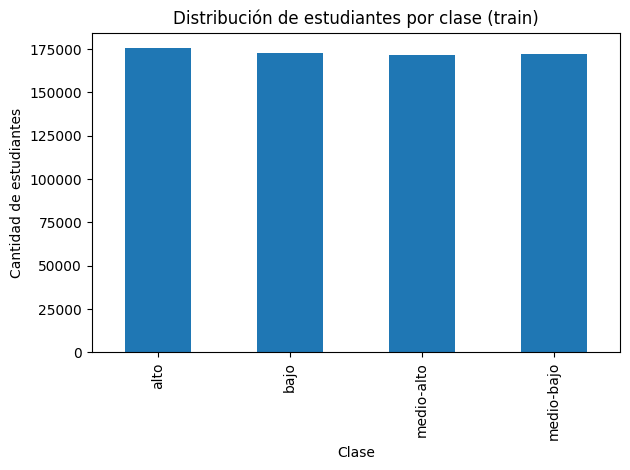

In [31]:
EXPECTED = {"bajo", "medio-bajo", "medio-alto", "alto"}

def infer_target(df):
    # por valores
    for c in df.columns:
        vals = set(str(x).strip().lower() for x in df[c].dropna().unique())
        if len(vals & EXPECTED) >= 2:
            return c
    # por nombre
    for c in df.columns:
        if re.search(r"(clase|desempe[nñ]o|nivel|target|label)", c, re.I):
            return c
    return None

target_col = infer_target(train)
print("Columna de clase:", target_col)

if target_col:
    serie = (train[target_col].astype(str).str.strip().str.lower()
             .replace({'medio bajo':'medio-bajo','medio alto':'medio-alto'}))
    vc = serie.value_counts().sort_index()
    display(vc)
    plt.figure()
    vc.plot(kind="bar")
    plt.title("Distribución de estudiantes por clase (train)")
    plt.xlabel("Clase")
    plt.ylabel("Cantidad de estudiantes")
    plt.tight_layout()
    plt.savefig(OUT_FIGS / "01_clases_train.png", dpi=300)
    plt.show()
else:
    print("No se detectó columna de clase automáticamente.")

## 3) Top 20 

Columna clave seleccionada: E_PRGM_DEPARTAMENTO


E_PRGM_DEPARTAMENTO
bogotá             282159
antioquia           83607
valle               44588
atlantico           41020
santander           28828
norte santander     22588
bolivar             20629
boyaca              14048
cundinamarca        14018
nariño              13454
risaralda           12679
cordoba             12188
tolima              11921
caldas              11640
cauca               11471
huila                9995
magdalena            9512
sucre                8674
cesar                8279
quindio              8229
Name: count, dtype: int64

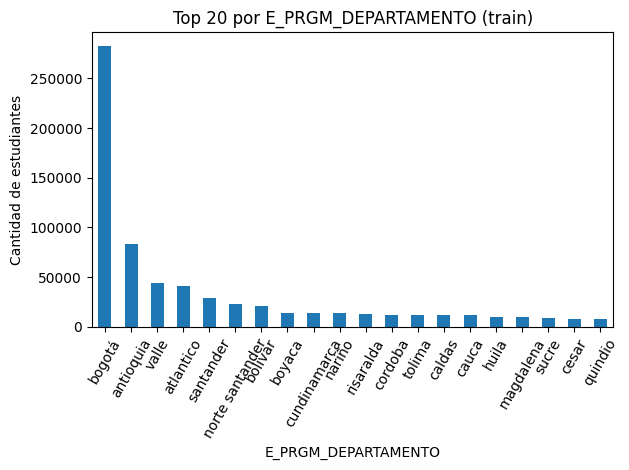

In [32]:
# Elegir UNA columna priorizando: geografía > programa > estrato > modalidad > institución
PRIORIDADES = [
    ["local", "ciud", "munic", "depar", "sede", "regi"],     # geografía
    ["program", "carrera"],                                   # programa
    ["estrato"],                                              # estrato
    ["modal", "jornada", "metodolog"],                        # modalidad
    ["institu", "universidad", "ies"]                         # institución
]

def pick_column(df):
    cols = list(df.columns)
    low = [c for c in cols if df[c].dtype == "object" or df[c].nunique(dropna=True) <= 50]
    for group in PRIORIDADES:
        for c in low:
            name = c.lower()
            if any(sub in name for sub in group):
                return c
    # fallback: primera categórica de baja cardinalidad
    return low[0] if low else None

col_key = pick_column(train)
print("Columna clave seleccionada:", col_key)

if col_key:
    vc = (train[col_key].astype(str).str.strip().str.lower()
          .value_counts().head(20))
    display(vc)
    plt.figure()
    vc.plot(kind="bar")
    plt.title(f"Top 20 por {col_key} (train)")
    plt.xlabel(col_key)
    plt.ylabel("Cantidad de estudiantes")
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.savefig(OUT_FIGS / f"02_top20_{col_key}_train.png", dpi=300)
    plt.show()
else:
    print("No se encontró una columna adecuada para conteo Top 20.")

## 4) Condiciones particulares

Columnas con faltantes (top 20):


F_TIENEAUTOMOVIL               43623
F_TIENELAVADORA                39773
F_TIENECOMPUTADOR              38103
F_ESTRATOVIVIENDA              32137
E_HORASSEMANATRABAJA           30857
F_TIENEINTERNET.1              26629
F_TIENEINTERNET                26629
F_EDUCACIONMADRE               23664
F_EDUCACIONPADRE               23178
E_PAGOMATRICULAPROPIO           6498
E_VALORMATRICULAUNIVERSIDAD     6287
dtype: int64

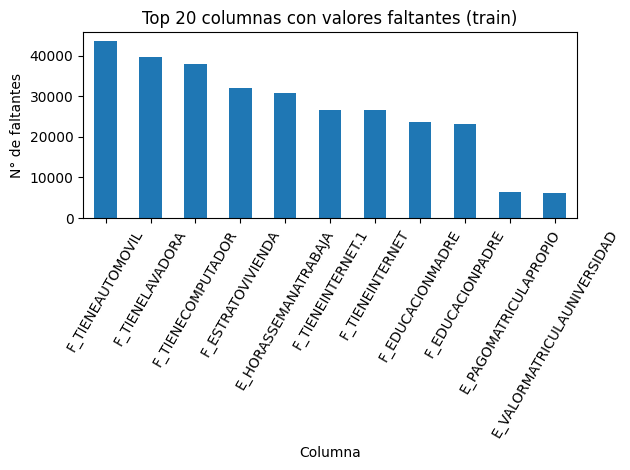

In [33]:
na = train.isna().sum().sort_values(ascending=False)
na = na[na > 0]
if len(na):
    print("Columnas con faltantes (top 20):")
    display(na.head(20))
    plt.figure()
    na.head(20).plot(kind="bar")
    plt.title("Top 20 columnas con valores faltantes (train)")
    plt.xlabel("Columna")
    plt.ylabel("N° de faltantes")
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.savefig(OUT_FIGS / "03_faltantes_train.png", dpi=300)
    plt.show()
else:
    print("Sin valores faltantes en train (o muy pocos).")